# KCW case study

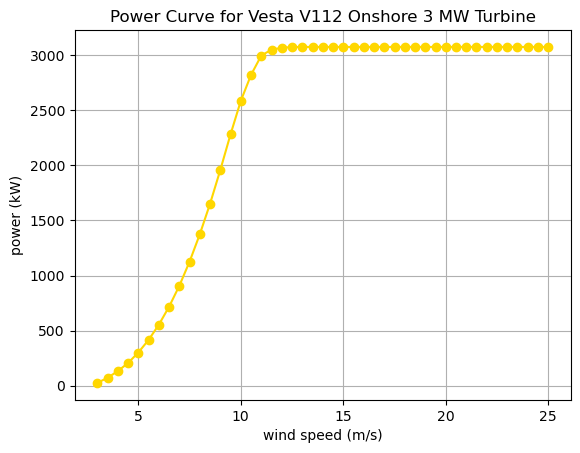

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

x = [3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25]
y = [26.00,73.00,133.00,207.00,302.00,416.00,554.00,717.00,907.00,1126.00,1375.00,1652.00,1958.00,2282.00,2585.00,2821.00,2997.00,3050.00,3067.00,3074.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00]

plt.plot(x, y, marker='o', color='gold')
plt.xlabel('wind speed (m/s)')
plt.ylabel('power (kW)')
plt.title('Power Curve for Vesta V112 Onshore 3 MW Turbine')
plt.grid(True)
plt.show()


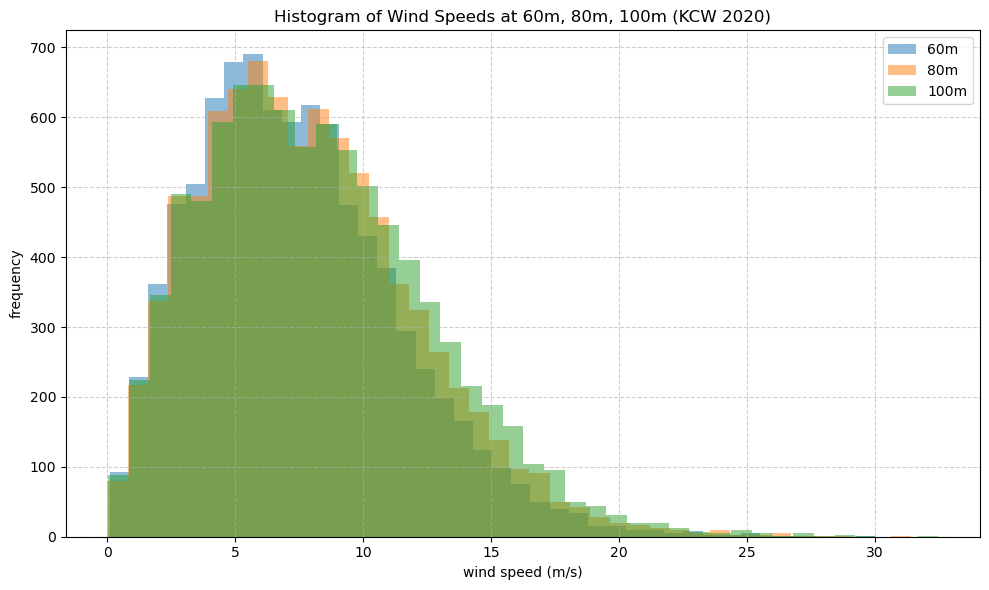

In [15]:
# Load the CSV file
df = pd.read_csv("./Kingdom_Community_wind.csv")

# Extract the wind speed columns
speed_60 = df["wind speed at 60m (m/s)"]
speed_80 = df["wind speed at 80m (m/s)"]
speed_100 = df["wind speed at 100m (m/s)"]

# Plot histograms for each height
plt.figure(figsize=(10, 6))
plt.hist(speed_60, bins=40, alpha=0.5, label="60m")
plt.hist(speed_80, bins=40, alpha=0.5, label="80m")
plt.hist(speed_100, bins=40, alpha=0.5, label="100m")

# Labels and title
plt.xlabel("wind speed (m/s)")
plt.ylabel("frequency")
plt.title("Histogram of Wind Speeds at 60m, 80m, 100m (KCW 2020)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()



In [13]:
print(df.columns)

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'wind direction at 60m (deg)',
       'wind speed at 60m (m/s)', 'wind direction at 80m (deg)',
       'wind speed at 80m (m/s)', 'wind direction at 100m (deg)',
       'wind speed at 100m (m/s)'],
      dtype='object')


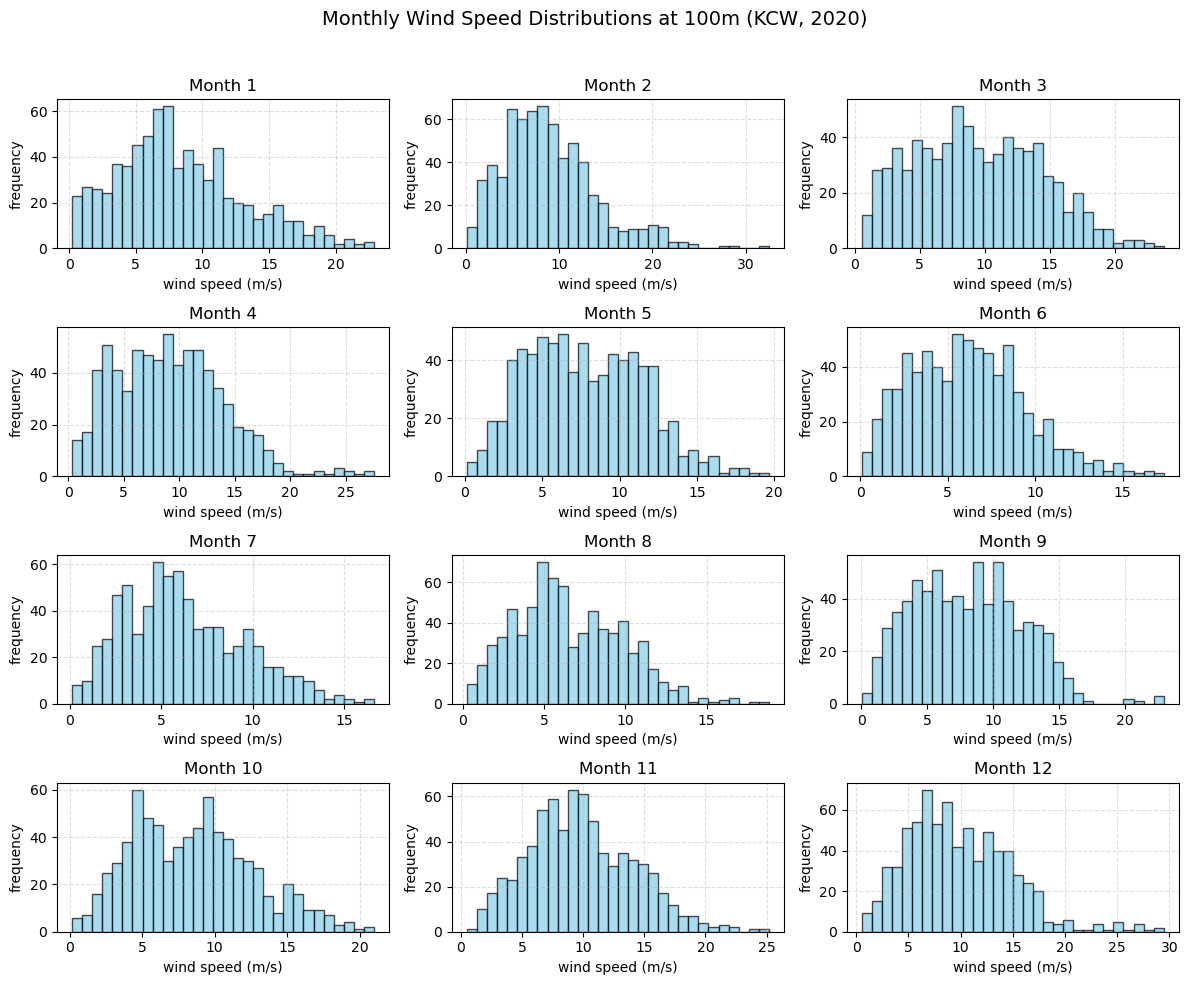

In [20]:
df["Month"] = pd.to_numeric(df["Month"], errors="coerce")

# Choose which height to analyze (100 m typically for turbines)
speed_col = "wind speed at 100m (m/s)"

# Create monthly histograms
months = range(1, 13)
plt.figure(figsize=(12, 10))

for month in months:
    plt.subplot(4, 3, month)
    data = df[df["Month"] == month][speed_col]
    plt.hist(data, bins=30, color="skyblue", alpha=0.7, edgecolor="k")
    plt.title(f"Month {month}")
    plt.xlabel("wind speed (m/s)")
    plt.ylabel("frequency")
    plt.grid(True, linestyle="--", alpha=0.4)

plt.suptitle("Monthly Wind Speed Distributions at 100m (KCW, 2020)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [30]:
# --- Define the turbine power curve ---
# Based on your earlier dataset (approximate values)
wind_speeds = np.array([3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25])
power_kw = np.array([26.00,73.00,133.00,207.00,302.00,416.00,554.00,717.00,907.00,1126.00,1375.00,1652.00,1958.00,2282.00,2585.00,2821.00,2997.00,3050.00,3067.00,3074.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00,3075.00])

# Interpolating function for the power curve
def turbine_power(v):
    """Returns turbine power output (kW) for given wind speed (m/s)."""
    if v < wind_speeds[0]:
        return 0
    elif v > wind_speeds[-1]:
        return 0  # cut-out speed
    else:
        return np.interp(v, wind_speeds, power_kw)

# Vectorize for speed
turbine_power_vec = np.vectorize(turbine_power)

# --- Apply to wind speed data ---
df["Power (kW)"] = turbine_power_vec(df["wind speed at 100m (m/s)"])

# --- Compute energy (kWh) ---
# Assume 10-minute data intervals → 1/6 hour
hours_per_record = 10 / 60
df["Energy (MWh)"] = df["Power (kW)"] * hours_per_record * 1e-3

# --- Aggregate monthly energy ---
monthly_energy = df.groupby("Month")["Energy (MWh)"].sum().reset_index()

# --- Optional: rename columns nicely ---
monthly_energy.columns = ["Month", "Estimated Energy (MWh)"]

# Netgen values from gridinfo.com (in MWh)
netgen_mwh = [5.5, 10, 19, 16, 17, 10, 12, 12, 16, 14, 19, 17.5]
monthly_energy["Net Gen (MWh)"] = netgen_mwh


monthly_energy["Net Gen Percent"] = [n * 100 / e if e != 0 else np.nan 
                                    for n, e in zip(netgen_mwh, monthly_energy["Estimated Energy (MWh)"])]


print(monthly_energy)

    Month  Estimated Energy (MWh)  Net Gen (MWh)  Net Gen Percent
0       1              184.527330            5.5         2.980588
1       2              177.593670           10.0         5.630831
2       3              222.190747           19.0         8.551211
3       4              204.855983           16.0         7.810365
4       5              178.349283           17.0         9.531858
5       6              110.602717           10.0         9.041369
6       7              119.196280           12.0        10.067428
7       8              132.731473           12.0         9.040810
8       9              181.777270           16.0         8.801981
9      10              197.749160           14.0         7.079676
10     11              230.649240           19.0         8.237617
11     12              222.316243           17.5         7.871670
